In [16]:
import torch
from torch import nn
from torch import optim
from torch.autograd import Variable
import torchvision

In [17]:
# All networks should inherit `nn.Module`
class Generator(nn.Module):
    """
    Takes a 100 element input vector and transforms
    it into an image with dimensions 64x64
    
    input is bacth_size x n_ch x width x height.
    In this case, (batch_size, 100, 1, 1)
    """
    
    # Note on convolutional transpose operations:
    # Input: (batch, chs_in, h_in, w_in)
    # Output: (batch, chs_out, h_out, w_out)
    # h_out = (h_in-1) * stride - 2 * padding + kernel
    
    # Anything with optimizable parameters needs to be
    # setup within the init method
    def __init__(self):
        super(Generator, self).__init__()
        self.main = nn.Sequential(
            
            # Hidden Layer 1
            nn.ConvTranspose2d(in_channels=100, 
                               out_channels=512,
                               kernel_size=4,
                               stride=1,
                               padding=0,
                               bias=False),
            nn.BatchNorm2d(num_features=512),
            nn.ReLU(),
            
            # Hidden Layer 2
            nn.ConvTranspose2d(in_channels=512,
                               out_channels=256,
                               kernel_size=4,
                               stride=2,
                               padding=1,
                               bias=False),
            nn.BatchNorm2d(num_features=256),
            nn.ReLU(),
            
            # Hidden Layer 3
            nn.ConvTranspose2d(in_channels=256,
                               out_channels=128,
                               kernel_size=4,
                               stride=2,
                               padding=1,
                               bias=False),
            nn.BatchNorm2d(num_features=128),
            nn.ReLU(),
            
            # Hidden Layer 4
            nn.ConvTranspose2d(in_channels=128,
                               out_channels=64,
                               kernel_size=4,
                               stride=2,
                               padding=1,
                               bias=False),
            nn.BatchNorm2d(num_features=64),
            nn.ReLU(),
            
            # Output Layer
            nn.ConvTranspose2d(in_channels=64, 
                               out_channels=1,
                               kernel_size=4,
                               stride=2,
                               padding=1,
                               bias=False),
            nn.Tanh()
        )
        
    # All modules must override `forward`
    def forward(self, x):
        x = self.main(x)
        return x

In [18]:
# Confirm the generator creates an image when given noise
# Map from (batch, 100, 1, 1) to (batch, 1, 32, 32)
# (batch, 100, 29, 29) to (batch, 1, 512, 512)
G = Generator()
G(torch.randn(12, 100, 29, 29)).shape

torch.Size([12, 1, 512, 512])

In [19]:
class Discriminator(nn.Module):
    """
    Takes in a 32x32 image and produces a decision
    about if that image is genuine or generated.
    
    Input is (bacth_size x n_ch x width x height)
    In this case (100, 1, 64, 64)
    """
    
    def __init__(self):
        super(Discriminator, self).__init__()
        
        # input is 1ch x 64w x 64h
        # nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding)
        self.main = nn.Sequential(
            
            # (batch_size, 1, 64, 64)
            nn.Conv2d(in_channels=1,
                      out_channels=64,
                      kernel_size=4,
                      stride=2,
                      padding=1, 
                      bias=False),
            nn.LeakyReLU(negative_slope=0.2),
            
            # (batch_size, 64, 32, 32)
            nn.Conv2d(in_channels=64,
                      out_channels=128,
                      kernel_size=4,
                      stride=2,
                      padding=1,
                      bias=False),
            nn.BatchNorm2d(num_features=128),
            nn.LeakyReLU(negative_slope=0.2),
            
            # (batch_size, 128, 16, 16)
            nn.Conv2d(in_channels=128,
                      out_channels=256,
                      kernel_size=4,
                      stride=2,
                      padding=1,
                      bias=False),
            nn.BatchNorm2d(num_features=256),
            nn.LeakyReLU(negative_slope=0.2),
            
            # (batch_size, 256, 8, 8)
            nn.Conv2d(in_channels=256,
                      out_channels=512,
                      kernel_size=4,
                      stride=2,
                      padding=1,
                      bias=False),
            nn.BatchNorm2d(num_features=512),
            nn.LeakyReLU(negative_slope=0.2),
            
            # (batch_size, 512, 4, 4)
            nn.Conv2d(in_channels=512,
                      out_channels=1,
                      kernel_size=4,
                      stride=1,
                      padding=0,
                      bias=False),
            
            # (batch_size, 1, 1, 1)
            nn.Sigmoid()
        )
        
        
    def forward(self, x):
        x = self.main(x)
        return x

In [20]:
# Confirm the discriminator produces a ruling given an image
# Map from (batch, 1, 64, 64) to (batch, 1, 1, 1)
D = Discriminator()
D(torch.randn(14, 1, 512, 512)).shape

torch.Size([14, 1, 29, 29])

In [24]:
def build_data_loader(batch_size):
    dataset = torchvision.datasets.ImageFolder(
        root='./chest_xray/train/',
        transform=torchvision.transforms.Compose([
            torchvision.transforms.Resize(64), # Make smallest dimension 32
            torchvision.transforms.CenterCrop(64), # Cut to square image
            torchvision.transforms.Grayscale(), # Convert to grayscale
            torchvision.transforms.ToTensor(), # Transform from PIL image to Tensor
        ]))
    
    return torch.utils.data.DataLoader(dataset, batch_size=batch_size)

In [25]:
# Utility methods for displaying data during training
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

def show_images(images):
    img = torchvision.utils.make_grid(images, normalize=True)
    npy_img = img.numpy()
    plt.imshow(np.transpose(npy_img, (1, 2, 0)),
               interpolation='nearest')
    plt.show()

torch.Size([8, 1, 64, 64])


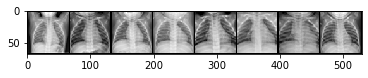

In [26]:
# Test on one a handful of images
# ...<rimshot.wav> :P
for data, _ in build_data_loader(8):
    test_images = data
    break
    
print(test_images.shape)
show_images(test_images)

# Perform Training

In [27]:
# Choose a loss function. Binary Cross Entropy Loss.
compute_loss = nn.BCELoss()

In [28]:
# Specify training details
n_epochs = 100
batch_size = 100

In [29]:
# Move everything to the GPU for training
gpu = torch.device(0)
G = G.to(gpu)
D = D.to(gpu)

In [30]:
# Create an optimizer to update the weights of each network
optimizer_d = optim.Adam(D.parameters(), lr=0.0002, betas=(0.5, 0.999))
optimizer_g = optim.Adam(G.parameters(), lr=0.0002, betas=(0.5, 0.999))

In [31]:
data_loader = build_data_loader(batch_size)
test_noise = torch.randn((8, 100, 1, 1)).to(gpu)

Epoch: 0/100
Example images:


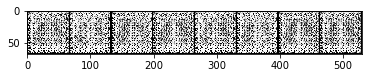

Epoch: 0	Batch: 13/14
Loss G: 7.465176105499268
Loss D: 0.002541007474064827
Epoch: 1/100
Example images:


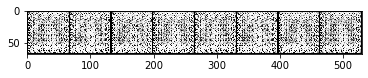

Epoch: 1	Batch: 13/14
Loss G: 7.677309989929199
Loss D: 0.0019003445049747825
Epoch: 2/100
Example images:


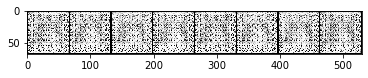

Epoch: 2	Batch: 13/14
Loss G: 7.5990753173828125
Loss D: 0.0018955087289214134
Epoch: 3/100
Example images:


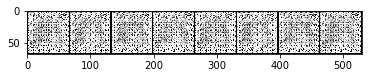

Epoch: 3	Batch: 13/14
Loss G: 7.865820407867432
Loss D: 0.001051135128363967
Epoch: 4/100
Example images:


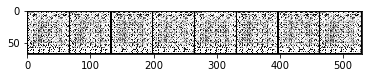

Epoch: 4	Batch: 13/14
Loss G: 7.856603622436523
Loss D: 0.0013351156376302242
Epoch: 5/100
Example images:


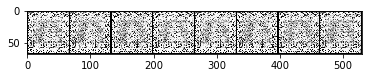

Epoch: 5	Batch: 13/14
Loss G: 9.004111289978027
Loss D: 0.0036275021266192198
Epoch: 6/100
Example images:


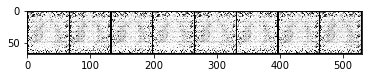

Epoch: 6	Batch: 13/14
Loss G: 11.131173133850098
Loss D: 0.8916399478912354
Epoch: 7/100
Example images:


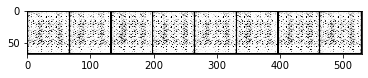

Epoch: 7	Batch: 13/14
Loss G: 11.245277404785156
Loss D: 0.007919542491436005
Epoch: 8/100
Example images:


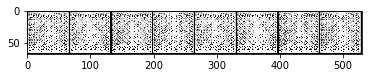

Epoch: 8	Batch: 13/14
Loss G: 14.769608497619629
Loss D: 0.4059520959854126
Epoch: 9/100
Example images:


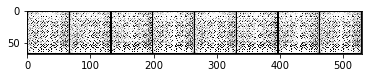

Epoch: 9	Batch: 13/14
Loss G: 15.612940788269043
Loss D: 0.7133286595344543
Epoch: 10/100
Example images:


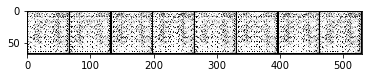

Epoch: 10	Batch: 13/14
Loss G: 11.552528381347656
Loss D: 0.08545158803462982
Epoch: 11/100
Example images:


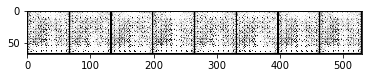

Epoch: 11	Batch: 13/14
Loss G: 6.703129291534424
Loss D: 0.07748396694660187
Epoch: 12/100
Example images:


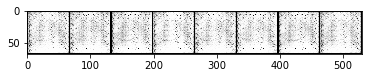

Epoch: 12	Batch: 13/14
Loss G: 1.863468885421753
Loss D: 1.3754096031188965
Epoch: 13/100
Example images:


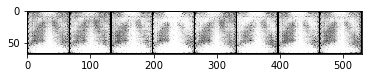

Epoch: 13	Batch: 13/14
Loss G: 1.0114836692810059
Loss D: 1.228827714920044
Epoch: 14/100
Example images:


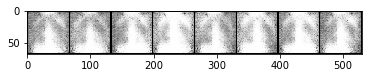

Epoch: 14	Batch: 13/14
Loss G: 0.46036389470100403
Loss D: 1.3391071557998657
Epoch: 15/100
Example images:


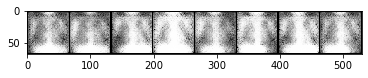

Epoch: 15	Batch: 13/14
Loss G: 5.8979997634887695
Loss D: 1.2541589736938477
Epoch: 16/100
Example images:


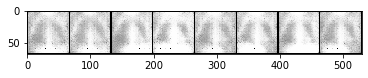

Epoch: 16	Batch: 13/14
Loss G: 1.721726894378662
Loss D: 0.917975902557373
Epoch: 17/100
Example images:


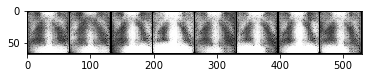

Epoch: 17	Batch: 13/14
Loss G: 3.9072189331054688
Loss D: 0.47388404607772827
Epoch: 18/100
Example images:


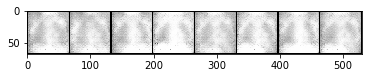

Epoch: 18	Batch: 13/14
Loss G: 2.8056650161743164
Loss D: 0.39022958278656006
Epoch: 19/100
Example images:


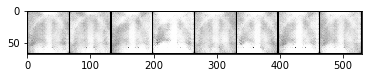

Epoch: 19	Batch: 13/14
Loss G: 2.3829846382141113
Loss D: 0.7891507744789124
Epoch: 20/100
Example images:


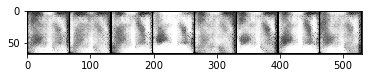

Epoch: 20	Batch: 13/14
Loss G: 1.7949717044830322
Loss D: 0.6099401116371155
Epoch: 21/100
Example images:


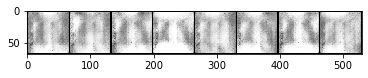

Epoch: 21	Batch: 13/14
Loss G: 4.068812370300293
Loss D: 0.519320011138916
Epoch: 22/100
Example images:


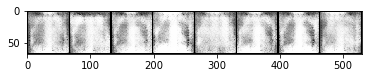

Epoch: 22	Batch: 13/14
Loss G: 0.43181777000427246
Loss D: 1.541387677192688
Epoch: 23/100
Example images:


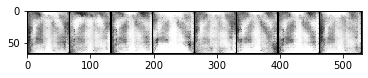

Epoch: 23	Batch: 13/14
Loss G: 3.9550046920776367
Loss D: 1.335641860961914
Epoch: 24/100
Example images:


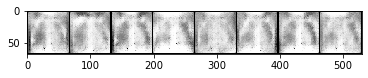

Epoch: 24	Batch: 13/14
Loss G: 2.095876455307007
Loss D: 0.7064306139945984
Epoch: 25/100
Example images:


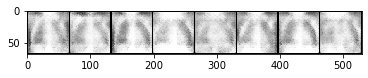

Epoch: 25	Batch: 13/14
Loss G: 5.5086259841918945
Loss D: 1.6801913976669312
Epoch: 26/100
Example images:


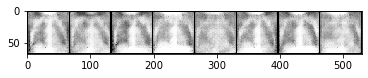

Epoch: 26	Batch: 13/14
Loss G: 2.4547207355499268
Loss D: 1.0204881429672241
Epoch: 27/100
Example images:


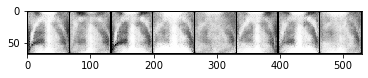

Epoch: 27	Batch: 13/14
Loss G: 2.398681640625
Loss D: 0.7268774509429932
Epoch: 28/100
Example images:


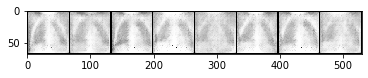

Epoch: 28	Batch: 13/14
Loss G: 1.9504644870758057
Loss D: 0.5634896159172058
Epoch: 29/100
Example images:


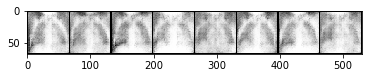

Epoch: 29	Batch: 13/14
Loss G: 1.5324751138687134
Loss D: 1.3216956853866577
Epoch: 30/100
Example images:


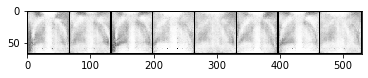

Epoch: 30	Batch: 13/14
Loss G: 0.9906354546546936
Loss D: 1.2649058103561401
Epoch: 31/100
Example images:


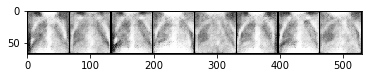

Epoch: 31	Batch: 13/14
Loss G: 0.29779303073883057
Loss D: 1.946074366569519
Epoch: 32/100
Example images:


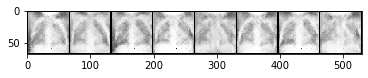

Epoch: 32	Batch: 13/14
Loss G: 2.1244008541107178
Loss D: 0.7527581453323364
Epoch: 33/100
Example images:


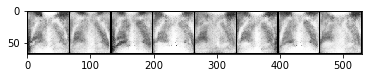

Epoch: 33	Batch: 13/14
Loss G: 0.5041622519493103
Loss D: 1.192044734954834
Epoch: 34/100
Example images:


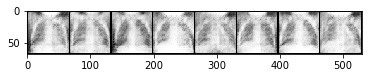

Epoch: 34	Batch: 13/14
Loss G: 2.0597925186157227
Loss D: 0.6220461130142212
Epoch: 35/100
Example images:


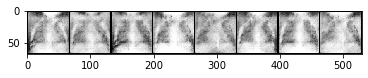

Epoch: 35	Batch: 13/14
Loss G: 4.112020969390869
Loss D: 0.5346111059188843
Epoch: 36/100
Example images:


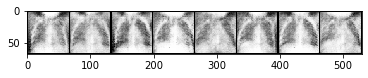

Epoch: 36	Batch: 13/14
Loss G: 2.326695442199707
Loss D: 0.9266583919525146
Epoch: 37/100
Example images:


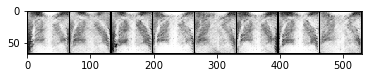

Epoch: 37	Batch: 13/14
Loss G: 3.9411909580230713
Loss D: 0.8239436149597168
Epoch: 38/100
Example images:


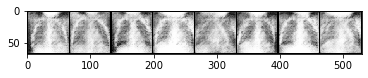

Epoch: 38	Batch: 13/14
Loss G: 2.072727680206299
Loss D: 0.8043420314788818
Epoch: 39/100
Example images:


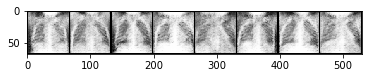

Epoch: 39	Batch: 13/14
Loss G: 2.986503839492798
Loss D: 0.6100320816040039
Epoch: 40/100
Example images:


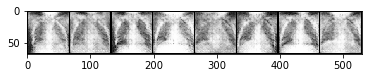

Epoch: 40	Batch: 13/14
Loss G: 2.0197246074676514
Loss D: 0.7016175985336304
Epoch: 41/100
Example images:


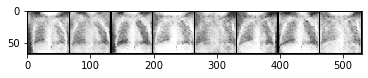

Epoch: 41	Batch: 13/14
Loss G: 3.9985036849975586
Loss D: 0.8199948072433472
Epoch: 42/100
Example images:


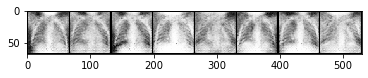

Epoch: 42	Batch: 13/14
Loss G: 4.530157566070557
Loss D: 3.366070032119751
Epoch: 43/100
Example images:


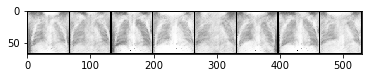

Epoch: 43	Batch: 13/14
Loss G: 3.5674538612365723
Loss D: 0.8502830862998962
Epoch: 44/100
Example images:


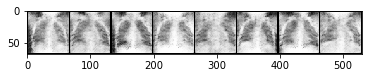

Epoch: 44	Batch: 13/14
Loss G: 4.1380109786987305
Loss D: 0.8629663586616516
Epoch: 45/100
Example images:


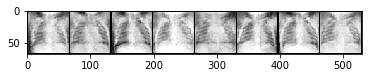

Epoch: 45	Batch: 13/14
Loss G: 3.7003519535064697
Loss D: 0.5885940790176392
Epoch: 46/100
Example images:


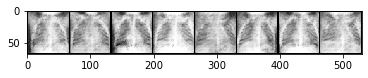

Epoch: 46	Batch: 13/14
Loss G: 2.1839187145233154
Loss D: 1.0302289724349976
Epoch: 47/100
Example images:


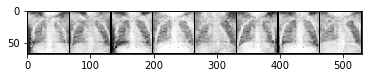

Epoch: 47	Batch: 13/14
Loss G: 1.8901623487472534
Loss D: 1.2145670652389526
Epoch: 48/100
Example images:


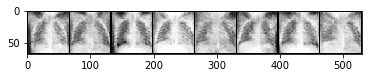

Epoch: 48	Batch: 13/14
Loss G: 4.24334192276001
Loss D: 0.7320139408111572
Epoch: 49/100
Example images:


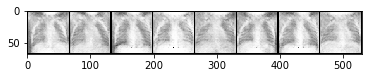

Epoch: 49	Batch: 13/14
Loss G: 2.948155403137207
Loss D: 2.0188658237457275
Epoch: 50/100
Example images:


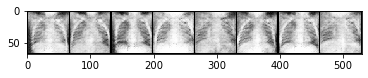

Epoch: 50	Batch: 13/14
Loss G: 2.997716188430786
Loss D: 0.5208958387374878
Epoch: 51/100
Example images:


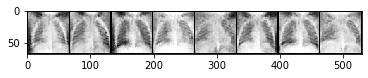

Epoch: 51	Batch: 13/14
Loss G: 2.0039992332458496
Loss D: 0.7027541399002075
Epoch: 52/100
Example images:


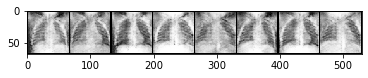

Epoch: 52	Batch: 13/14
Loss G: 4.178651809692383
Loss D: 1.024234414100647
Epoch: 53/100
Example images:


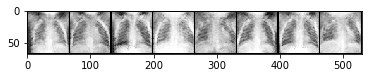

Epoch: 53	Batch: 13/14
Loss G: 2.4255759716033936
Loss D: 0.5953099131584167
Epoch: 54/100
Example images:


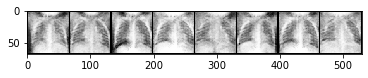

Epoch: 54	Batch: 13/14
Loss G: 3.092775821685791
Loss D: 0.6083766222000122
Epoch: 55/100
Example images:


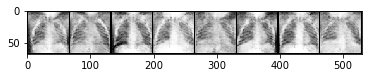

Epoch: 55	Batch: 13/14
Loss G: 4.517104625701904
Loss D: 0.743361234664917
Epoch: 56/100
Example images:


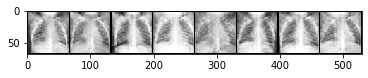

Epoch: 56	Batch: 13/14
Loss G: 2.6108415126800537
Loss D: 0.6558603644371033
Epoch: 57/100
Example images:


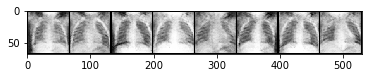

Epoch: 57	Batch: 13/14
Loss G: 4.853918075561523
Loss D: 0.8920916318893433
Epoch: 58/100
Example images:


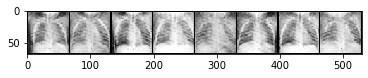

Epoch: 58	Batch: 13/14
Loss G: 2.114718198776245
Loss D: 0.6683724522590637
Epoch: 59/100
Example images:


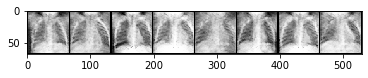

Epoch: 59	Batch: 13/14
Loss G: 5.460341930389404
Loss D: 0.8517733216285706
Epoch: 60/100
Example images:


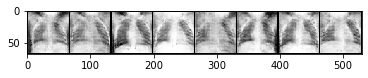

Epoch: 60	Batch: 13/14
Loss G: 2.3346235752105713
Loss D: 0.5399097800254822
Epoch: 61/100
Example images:


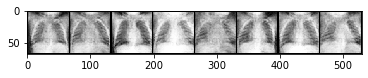

Epoch: 61	Batch: 13/14
Loss G: 4.30514669418335
Loss D: 0.6896950006484985
Epoch: 62/100
Example images:


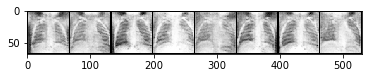

Epoch: 62	Batch: 13/14
Loss G: 2.8336808681488037
Loss D: 1.2425215244293213
Epoch: 63/100
Example images:


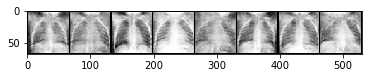

Epoch: 63	Batch: 13/14
Loss G: 3.4967784881591797
Loss D: 0.46564173698425293
Epoch: 64/100
Example images:


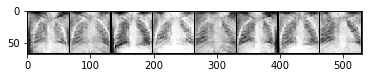

Epoch: 64	Batch: 13/14
Loss G: 3.5964138507843018
Loss D: 0.7718874216079712
Epoch: 65/100
Example images:


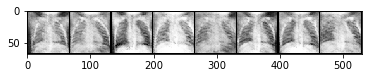

Epoch: 65	Batch: 13/14
Loss G: 4.33799934387207
Loss D: 0.5490652322769165
Epoch: 66/100
Example images:


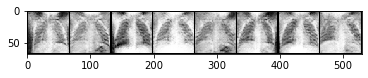

Epoch: 66	Batch: 13/14
Loss G: 2.7346389293670654
Loss D: 0.5410376191139221
Epoch: 67/100
Example images:


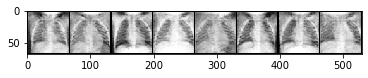

Epoch: 67	Batch: 13/14
Loss G: 6.296515941619873
Loss D: 0.7820386290550232
Epoch: 68/100
Example images:


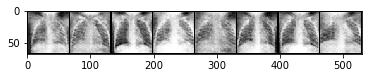

Epoch: 68	Batch: 13/14
Loss G: 3.3732035160064697
Loss D: 0.4644440710544586
Epoch: 69/100
Example images:


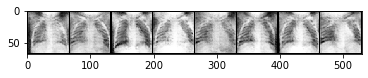

Epoch: 69	Batch: 13/14
Loss G: 4.918397903442383
Loss D: 0.795707106590271
Epoch: 70/100
Example images:


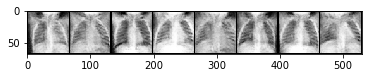

Epoch: 70	Batch: 13/14
Loss G: 1.3695703744888306
Loss D: 0.729485273361206
Epoch: 71/100
Example images:


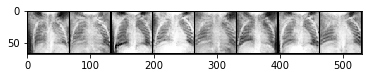

Epoch: 71	Batch: 13/14
Loss G: 3.648122787475586
Loss D: 0.6358834505081177
Epoch: 72/100
Example images:


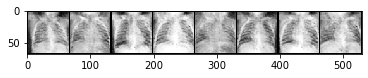

Epoch: 72	Batch: 13/14
Loss G: 4.3105998039245605
Loss D: 0.5304349660873413
Epoch: 73/100
Example images:


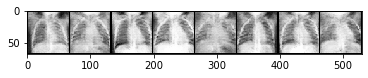

Epoch: 73	Batch: 13/14
Loss G: 2.2332358360290527
Loss D: 0.7094703912734985
Epoch: 74/100
Example images:


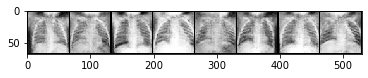

Epoch: 74	Batch: 13/14
Loss G: 3.5289721488952637
Loss D: 0.55294269323349
Epoch: 75/100
Example images:


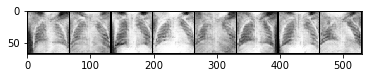

Epoch: 75	Batch: 13/14
Loss G: 2.3472442626953125
Loss D: 0.6296687126159668
Epoch: 76/100
Example images:


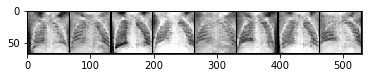

Epoch: 76	Batch: 13/14
Loss G: 3.062032461166382
Loss D: 0.34680938720703125
Epoch: 77/100
Example images:


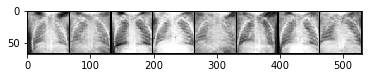

Epoch: 77	Batch: 13/14
Loss G: 2.465021848678589
Loss D: 0.7904993891716003
Epoch: 78/100
Example images:


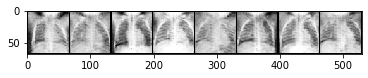

Epoch: 78	Batch: 13/14
Loss G: 1.2655080556869507
Loss D: 0.8827006220817566
Epoch: 79/100
Example images:


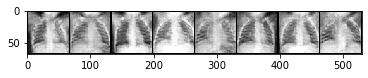

Epoch: 79	Batch: 13/14
Loss G: 4.71999454498291
Loss D: 0.4847530424594879
Epoch: 80/100
Example images:


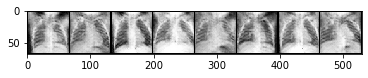

Epoch: 80	Batch: 13/14
Loss G: 3.9530482292175293
Loss D: 0.2777186930179596
Epoch: 81/100
Example images:


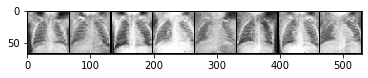

Epoch: 81	Batch: 13/14
Loss G: 3.2385237216949463
Loss D: 0.5783040523529053
Epoch: 82/100
Example images:


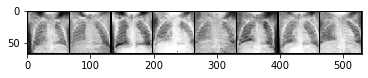

Epoch: 82	Batch: 13/14
Loss G: 6.620201587677002
Loss D: 0.5940700173377991
Epoch: 83/100
Example images:


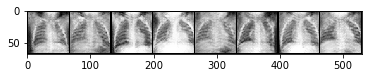

Epoch: 83	Batch: 13/14
Loss G: 4.499949932098389
Loss D: 0.6126534342765808
Epoch: 84/100
Example images:


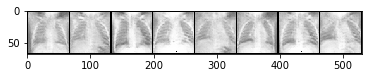

Epoch: 84	Batch: 13/14
Loss G: 3.1310508251190186
Loss D: 0.33042261004447937
Epoch: 85/100
Example images:


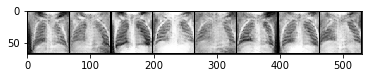

Epoch: 85	Batch: 13/14
Loss G: 2.490429639816284
Loss D: 0.565278947353363
Epoch: 86/100
Example images:


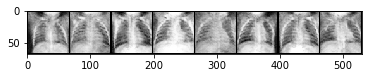

Epoch: 86	Batch: 13/14
Loss G: 4.455896377563477
Loss D: 0.48371145129203796
Epoch: 87/100
Example images:


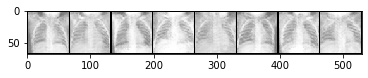

Epoch: 87	Batch: 13/14
Loss G: 2.770216941833496
Loss D: 0.3239956498146057
Epoch: 88/100
Example images:


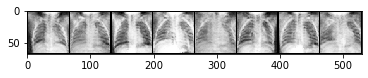

Epoch: 88	Batch: 13/14
Loss G: 7.259358882904053
Loss D: 0.8120769262313843
Epoch: 89/100
Example images:


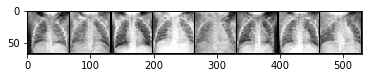

Epoch: 89	Batch: 13/14
Loss G: 2.8542072772979736
Loss D: 0.36370500922203064
Epoch: 90/100
Example images:


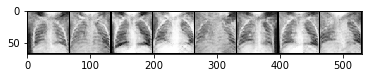

Epoch: 90	Batch: 13/14
Loss G: 3.5134758949279785
Loss D: 0.32572099566459656
Epoch: 91/100
Example images:


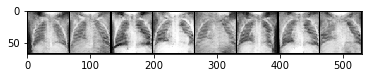

Epoch: 91	Batch: 13/14
Loss G: 5.657859802246094
Loss D: 0.4609602093696594
Epoch: 92/100
Example images:


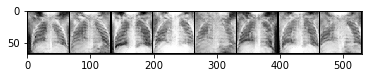

Epoch: 92	Batch: 13/14
Loss G: 5.944616794586182
Loss D: 0.5929306745529175
Epoch: 93/100
Example images:


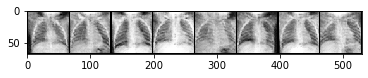

Epoch: 93	Batch: 13/14
Loss G: 1.4698795080184937
Loss D: 1.2127516269683838
Epoch: 94/100
Example images:


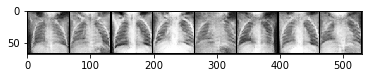

Epoch: 94	Batch: 13/14
Loss G: 3.598942995071411
Loss D: 0.31434234976768494
Epoch: 95/100
Example images:


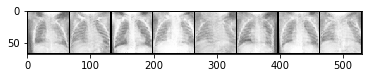

Epoch: 95	Batch: 13/14
Loss G: 3.349041223526001
Loss D: 0.2551829218864441
Epoch: 96/100
Example images:


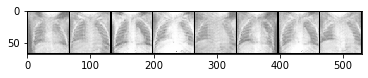

Epoch: 96	Batch: 13/14
Loss G: 3.089231491088867
Loss D: 0.3013099133968353
Epoch: 97/100
Example images:


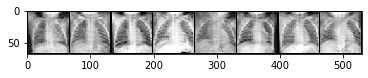

Epoch: 97	Batch: 13/14
Loss G: 8.622876167297363
Loss D: 0.9825434684753418
Epoch: 98/100
Example images:


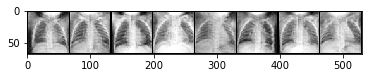

Epoch: 98	Batch: 13/14
Loss G: 1.694941520690918
Loss D: 0.5850378274917603
Epoch: 99/100
Example images:


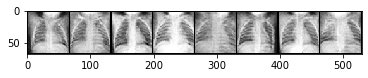

Epoch: 99	Batch: 13/14
Loss G: 4.888606071472168
Loss D: 0.46015894412994385


In [35]:
j=0
for epoch in range(n_epochs):
    print(f"Epoch: {epoch}/{n_epochs}")
    print("Example images:")
    generated_images = G(test_noise).detach().cpu()
    show_images(generated_images)
    j +=1
    for i, (batch, _) in enumerate(data_loader):
        print(f"\rEpoch: {epoch}\tBatch: {i}/{len(data_loader)}", end='')
        ## Train the discriminiator ##
        D.zero_grad()

        # Compute error on real data
        real = Variable(batch).to(gpu)
        real_labels = Variable(torch.ones(real.size(0), 1, 1, 1)).to(gpu)
        real_predictions = D(real)
        d_error_real = compute_loss(real_predictions, real_labels)
        
        # Compute error on fake data
        noise = Variable(torch.randn(real.size(0), 100, 1, 1)).to(gpu)
        fake = G(noise)
        fake_predictions = D(fake.detach())
        fake_labels = Variable(torch.zeros(real.size(0), 1, 1, 1)).to(gpu)
        d_error_fake = compute_loss(fake_predictions, fake_labels)
        
        # Accumulate and backpropogate on combined error
        d_error_total = d_error_real + d_error_fake
        d_error_total.backward()
        optimizer_d.step()
        
        ## Train the generator ##
        G.zero_grad()
        
        # Compute rate of fakes being detected
        goal_labels = Variable(torch.ones(real.size(0), 1, 1, 1)).to(gpu)
        results = D(fake)
        g_error = compute_loss(results, goal_labels)
        
        # Backpropogate and update weights
        g_error.backward()
        optimizer_g.step()
    torch.save(G.state_dict(), f"trained_generator_{j}th")
    
    print("")
    print(f"Loss G: {g_error}")
    print(f"Loss D: {d_error_total}")